# Import Packages

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, average_precision_score, make_scorer, mean_absolute_error, median_absolute_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# Load Data

In [2]:
df = pd.read_csv("../data/prepped_data.csv", low_memory=False, index_col=0).drop_duplicates()

df = df[df["first_data_year"] >= 2021]

# Setup Model

In [3]:
categorical_features = []
continuous_features = []
binary_features = []

# Define a threshold for the maximum number of unique values for a categorical column
max_unique_values_for_categorical = 10

# Iterate through each column to determine if it's categorical, continuous, or binary
for column in df.columns:
    unique_values = df[column].nunique()
    if unique_values == 2:
        # If exactly 2 unique values, treat column as binary
        binary_features.append(column)
    elif (df[column].dtype == 'object' or unique_values <= max_unique_values_for_categorical) and unique_values > 2:
        # If object type or up to the threshold of unique values (and more than 2), treat as categorical
        categorical_features.append(column)
    else:
        # Otherwise, treat as continuous
        continuous_features.append(column)

categorical_features = [col for col in categorical_features if col != "years_since_last_car_change"]
continuous_features = continuous_features + ["years_since_last_car_change"]

print(f'Binary Features: {binary_features}')
print(f'Categorical Features: {categorical_features}')
print(f'Continuous Features: {continuous_features}')

# df = pd.get_dummies(df, columns=categorical_features)

for cat in categorical_features:
     df[cat] = df[cat].astype("category")

Binary Features: ['churn', 'last_allrisk basis', 'last_allrisk compleet', 'last_allrisk royaal', 'last_wa-extra', 'fake_alarm', 'policyholder_change', 'n_last_vs_peak', 'lpa']
Categorical Features: ['policy_nr_hashed', 'last_data_year', 'first_data_year', 'control_group', 'last_brand', 'last_type', 'last_fuel_type', 'last_postcode', 'last_product', 'nr_cars', 'max_nr_coverages', 'last_nr_coverages', 'last_trend_nr_coverages', 'last_year_car_change']
Continuous Features: ['welcome_discount', 'first_premium', 'last_premium', 'first_split', 'last_split', 'last_customer_age', 'last_accident_free_years', 'last_car_value', 'last_age_car', 'last_weight', 'accident_years', 'last_change_premium_abs', 'last_change_premium_perc', 'last_vs_first_split', 'cum_change_premium_abs', 'cum_change_premium_perc', 'years_since_last_car_change']


In [4]:
# cols_to_drop_manual = ["first_split", "first_premium", "nr_cars", "last_type", "last_brand", 'last_weight', 'n_last_vs_peak', 'last_fuel_type', 'last_trend_nr_coverages', 'last_change_premium_abs', 'last_change_premium_perc', 'max_nr_coverages', 'last_nr_coverages',]
cols_to_drop = ["churn", "policy_nr_hashed", "last_data_year", "first_data_year", "control_group", 'welcome_discount']
selected_columns = [col for col in df.columns if not any(col.startswith(prefix) for prefix in cols_to_drop)]

X = df[selected_columns]
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Model Selection

In [6]:
space = {
    'max_depth': hp.uniformint('max_depth', 50, 100),
    'n_estimators': hp.uniformint('n_estimators', 50, 200),
    'num_leaves': hp.uniformint('num_leaves', 2, 200),
    'min_child_samples': hp.uniformint('min_child_samples', 7, 100),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.25, 1),
    'subsample': hp.uniform('subsample', 0.25, 1),
    'subsample_freq': hp.uniformint('subsample_freq', 1, 100),
    'reg_alpha': hp.uniform('reg_alpha', 0, 0.2),
    'reg_lambda': hp.uniform('reg_lambda', 0, 0.2),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.5),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'min_data_in_leaf': hp.uniformint('min_data_in_leaf', 1, 21),
}

def objective(params):
    clf = lgb.LGBMClassifier(
        objective='binary',
        force_row_wise=True,
        verbosity=-1,
        # is_unbalance=True,
        **params
    )
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring="neg_brier_score").mean()
    return {'loss': -score, 'status': STATUS_OK}

n_iter = 50
trials = Trials()

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=n_iter, trials=trials, rstate=np.random.RandomState(0))

print("Best Score is: ", -trials.best_trial['result']['loss'])
print("Best Parameters: ", best)

100%|██████████| 50/50 [02:32<00:00,  3.04s/trial, best loss: 0.10895153945982257]
Best Score is:  -0.10895153945982257
Best Parameters:  {'colsample_bytree': 0.2983935721861137, 'learning_rate': 0.04740706929909022, 'max_depth': 59.0, 'min_child_samples': 18.0, 'min_data_in_leaf': 13.0, 'min_split_gain': 0.3863623673164322, 'n_estimators': 74.0, 'num_leaves': 54.0, 'reg_alpha': 0.1198683978345154, 'reg_lambda': 0.18168767473399486, 'subsample': 0.9841777438197711, 'subsample_freq': 27.0}


In [9]:
# best = {'colsample_bytree': 0.2983935721861137, 'learning_rate': 0.04740706929909022, 'max_depth': 59.0, 'min_child_samples': 18.0, 'min_data_in_leaf': 13.0, 'min_split_gain': 0.3863623673164322, 'n_estimators': 74.0, 'num_leaves': 54.0, 'reg_alpha': 0.1198683978345154, 'reg_lambda': 0.18168767473399486, 'subsample': 0.9841777438197711, 'subsample_freq': 27.0}

best_params = {
    'max_depth': int(best['max_depth']),
    'n_estimators': int(best['n_estimators']),
    'num_leaves': int(best['num_leaves']),
    'min_child_samples': int(best['min_child_samples']),
    'colsample_bytree': best['colsample_bytree'],
    'subsample': best['subsample'],
    'subsample_freq': int(best['subsample_freq']),
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda'],
    'min_split_gain': best['min_split_gain'],
    'learning_rate': best['learning_rate'],
    'min_data_in_leaf': int(best['min_data_in_leaf']),
}

lgbm_best = lgb.LGBMClassifier(
    objective='binary',
    force_row_wise=True,
    verbosity=-1,
    # is_unbalance=True,
    **best_params
)

# Validation

In [10]:
def mae_prob(y_true, y_pred_probs):
    return mean_absolute_error(y_true, y_pred_probs)

def medae_prob(y_true, y_pred_probs):
    return median_absolute_error(y_true, y_pred_probs)

mae_prob_scorer = make_scorer(mae_prob, needs_proba=True)
medae_prob_scorer = make_scorer(medae_prob, needs_proba=True)

In [11]:
scores_brier = cross_val_score(lgbm_best, X, y, cv=5, scoring='neg_brier_score')
scores_log_loss = cross_val_score(lgbm_best, X, y, cv=5, scoring='neg_log_loss')
scores_mae = cross_val_score(lgbm_best, X, y, cv=5, scoring=mae_prob_scorer)
scores_medae = cross_val_score(lgbm_best, X, y, cv=5, scoring=medae_prob_scorer)

print('CV Average Brier score: {0:0.4f}'.format(-np.mean(scores_brier)))
print('CV Average Log Loss: {0:0.4f}'.format(-np.mean(scores_log_loss)))
print('CV Average Root Brier score: {0:0.4f}'.format(np.sqrt(-np.mean(scores_brier))))
print('CV MAE: {0:0.4f}'.format(np.mean(scores_mae)))
print('CV MedAE: {0:0.4f}'.format(np.mean(scores_medae)))

CV Average Brier score: 0.1066
CV Average Log Loss: 0.3535
CV Average Root Brier score: 0.3266
CV MAE: 0.2143
CV MedAE: 0.1207


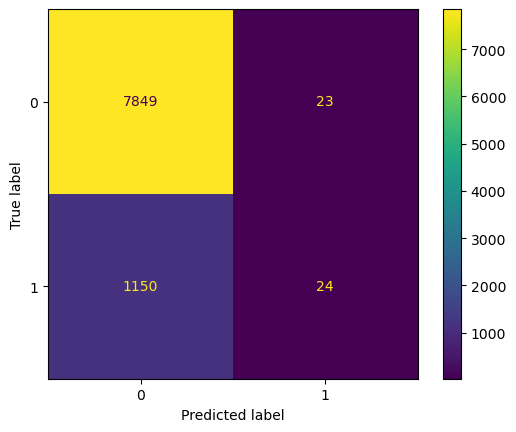

In [65]:
lgbm_best.fit(X_train, y_train)

threshold = 0.5
probabilities = lgbm_best.predict_proba(X_test)[:, 1]
y_pred = np.abs(np.ceil(np.array(probabilities) - threshold)).astype("int")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbm_best.classes_)
disp.plot()
plt.show()